In [2]:
import numpy as np
import matplotlib.pyplot as plt

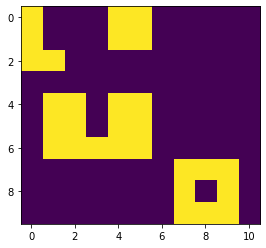

In [3]:
test = np.ones([10, 11], dtype=np.uint8)
test[:3,0] = 0
test[2,1] = 0
test[:2,4:6] = 0

test[4:6,4:6] = 0
test[4:6,1:3] = 0
test[6:7,1:6] = 0

test[7:10,7:10] = 0
test[8,8] = 1
test = 1 - test
plt.imshow(test)

In [4]:
test.shape

(10, 11)

In [5]:
def groups_by_rows(img_arr):
    grps_by_rows = []
    g_c = 0
    current_row = []
    for row in range(img_arr.shape[0]):  # пройтись по строкам
        indexes = np.asarray(img_arr[row] == 1).nonzero()[0] # найти индексы единиц
        if indexes.size == 0:
            grps_by_rows.append([])
            continue
        gaps = np.diff(indexes) > 1  # найти разрывы между ними
        gaps = np.concatenate([gaps, [True]])
        current_group = []
        for index, gap in dict(zip(indexes, gaps)).items():
            current_group.append(index)
            if gap:
                current_row.append(current_group * 2 if len(current_group) == 1 else [current_group[0], current_group[-1]])
                current_group = []
        grps_by_rows.append(current_row)
        current_row = []
    return grps_by_rows

grps_by_rows = groups_by_rows(test)

In [6]:
def check_connectivity(arr, group_borders, row_number, groups_obj):
    """
    must return a group(s) that group_borders belong(s) to.
    """
    if row_number == 0: # create new group as it is row 1
        last_gr_number = list(groups_obj.keys())[-1:]
        last_gr_number = 0 if last_gr_number == [] else last_gr_number[0]+1
        groups_obj.update({last_gr_number: np.array([
            [[row_number,group_borders[0]], [row_number,group_borders[1]]],
        ])
                          })
        return groups_obj
    
    candidates_j_range = [
        group_borders[0]-1 if group_borders[0] != 0 else 0, 
        group_borders[1]+1
    ]
    candidates_i = row_number-1 if row_number != 0 else 0
    canndidates_connect_to = arr[candidates_i,candidates_j_range[0]:candidates_j_range[1]+1]
    if all(canndidates_connect_to == 0):
        last_gr_number = list(groups_obj.keys())[-1:]
        last_gr_number = 0 if last_gr_number == [] else last_gr_number[0]+1
        groups_obj.update({last_gr_number: np.array([
            [[row_number,group_borders[0]], [row_number,group_borders[1]]],
        ])
                          })
        return groups_obj
    group_concatination = [False] * len(groups_obj)
    to_pop = []
    to_drop_duplicates = []
    for j, (k, v) in enumerate(groups_obj.items()):
        for n, element in enumerate(v):
            candidates_j_range_set = set(range(candidates_j_range[0], candidates_j_range[1]+1))
            if element[:,0][0] == candidates_i and set(range(element[:,1][0], element[:,1][1]+1)).intersection(candidates_j_range_set):
                group_concatination[j] = True
                too_ssstak = np.array([[[row_number,group_borders[0]], 
                                        [row_number,group_borders[1]]],
                                         ])
                groups_obj[k] = np.concatenate([groups_obj[k], 
                                                 too_ssstak]
                                                )
                # Concatinate to existing group
                if np.where(group_concatination)[0].shape[0] > 1:
                    to_pop.append(k)
                    gr_concat_to = np.where(group_concatination)[0][0]
                    to_drop_duplicates.append(gr_concat_to)
                    groups_obj[gr_concat_to] = np.concatenate([groups_obj[gr_concat_to], 
                                                               groups_obj[k]])
    if to_pop:
        [groups_obj.pop(pop) for pop in to_pop if pop in groups_obj]
    if to_drop_duplicates:
        [np.unique(groups_obj[dupl], axis=0) for dupl in to_drop_duplicates]
    groups_obj = dict(zip(list(range(len(groups_obj))), groups_obj.values()))
    return groups_obj
        

grps = {}
for r_num, row in enumerate(grps_by_rows):
    for group in row:
        if group == []:
            continue
        grps = check_connectivity(test, group, r_num, grps)
# grps

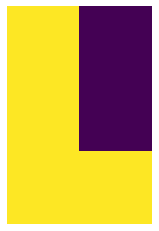

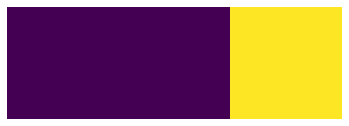

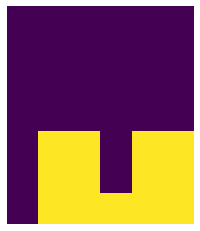

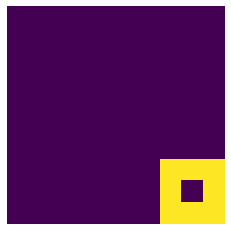

In [7]:

def show_segment(coords):
    max_y = max(coords[:,0,0])
    max_x = max(coords[:,1,1])
    img = np.zeros([max_y+1, max_x+1])
    for border_index in range(coords.shape[0]):
        row = coords[border_index][0][0]
        cols = coords[border_index][:,1]
        cols = cols if cols[1]-cols[0] < 2 else list(range(cols[0], cols[1]+1, 1))
        for col in cols:
            img[row][col] = 1
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
for i in grps.values():
    show_segment(i)